In [54]:
# !pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm fastapi


In [55]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/taxi_trip_pricing.csv')

df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [57]:
df.describe()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,951.000000
mean,27.070547,2.476842,3.502989,1.233316,0.292916,62.118116,56.874773
std,19.905300,1.102249,0.870162,0.429816,0.115592,32.154406,40.469791
min,1.230000,1.000000,2.010000,0.500000,0.100000,5.010000,6.126900
25%,12.632500,1.250000,2.730000,0.860000,0.190000,35.882500,33.742650
50%,25.830000,2.000000,3.520000,1.220000,0.290000,61.860000,50.074500
75%,38.405000,3.000000,4.260000,1.610000,0.390000,89.055000,69.099350
max,146.067047,4.000000,5.000000,2.000000,0.500000,119.840000,332.043689


In [58]:
df.isnull().sum()

,0
Trip_Distance_km,50
Time_of_Day,50
Day_of_Week,50
Passenger_Count,50
Traffic_Conditions,50
Weather,50
Base_Fare,50
Per_Km_Rate,50
Per_Minute_Rate,50
Trip_Duration_Minutes,50


In [59]:
df = df.dropna(subset=['Trip_Price'])

In [60]:
df = df.dropna()

In [61]:
df.isnull().sum()

,0
Trip_Distance_km,0
Time_of_Day,0
Day_of_Week,0
Passenger_Count,0
Traffic_Conditions,0
Weather,0
Base_Fare,0
Per_Km_Rate,0
Per_Minute_Rate,0
Trip_Duration_Minutes,0


In [62]:
numeric_columns = df.select_dtypes(include=[np.number]).columns


def remove_outliers(data, cols, multiplier=1.5):
     df_out = data.copy()
     for col in cols:
         if df_out[col].isnull().all():
           continue
         Q1 = df_out[col].quantile(0.25)
         Q3 = df_out[col].quantile(0.75)
         IQR = Q3 - Q1
         lower_bound = Q1 - multiplier * IQR
         upper_bound = Q3 + multiplier * IQR
         df_out = df_out[(df_out[col] >= lower_bound) & (df_out[col] <= upper_bound)]
     return df_out

df = remove_outliers(df, numeric_columns)


In [63]:
df.shape

(544, 11)

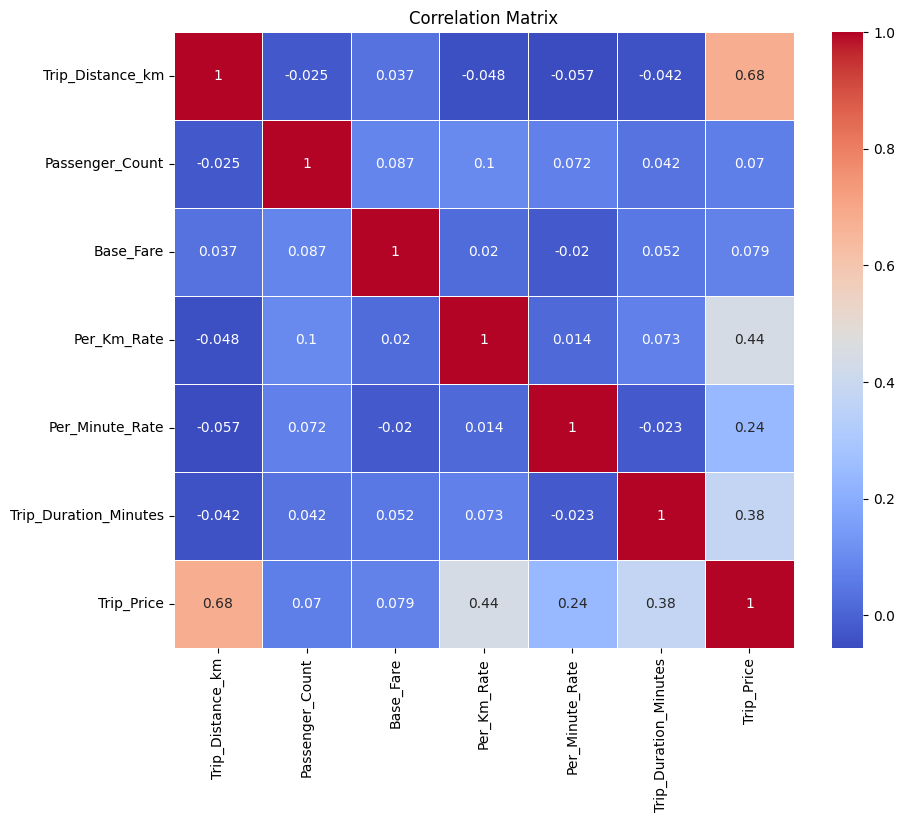

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df[numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [65]:
df["Average_Speed_km_hr"] = df["Trip_Distance_km"] / (df["Trip_Duration_Minutes"]/60.0)

In [66]:
traffic_mapping = {"Low":1, "Medium":2, "High":3}
df["Traffic_Conditions"] = df["Traffic_Conditions"].map(traffic_mapping)

In [68]:
target = "Trip_Price"
features = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare','Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes','Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather', 'Average_Speed_km_hr']




X = df[features]
y = df[target]


In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (435, 11)
Testing set shape: (109, 11)


In [70]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [71]:
numeric_features = ['Trip_Distance_km', 'Passenger_Count', 'Base_Fare','Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes', 'Traffic_Conditions',  'Average_Speed_km_hr']


categorical_features = ['Time_of_Day', 'Day_of_Week', 'Weather']


numeric_transformer = Pipeline(steps=[('scaler', StandardScaler)])


categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder)])


preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer),('cat', categorical_transformer)])



